volume diff 와 liquidation diff 에서 큰 상관관계 확인

두 값을 예측하는 모델. 이전 5개의 buy volume 값, sell volume 값을 예측하는 모델

혹은

long_liquidations, short_liqudations 까지 예측하는 모델 만들고

train에서 이후 buy volume 값, sell volume 값, long_liqudations, short_liqudations 값까지 feature로 해서 예측하는 모델 만들고 학습

이후에 test에서는 직접 만들어준 변수를 넣어서 최종 제출

# Base Model

In [2]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
# 파일 호출
data_path: str = "./data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [4]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:01<00:00, 101.44it/s]


In [5]:
import random
import torch
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
seed=42
set_seed(seed)

In [6]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 19)

In [7]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [8]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    # future shift df
    df_future_shift_dict = [
        df[conti_col].shift(-1).rename(f"{conti_col}_{-1}")
        for conti_col in conti_cols
    ]
    df_shift_dict.extend(df_future_shift_dict)
    
    return df_shift_dict

# test에서 shift 된 것은 사용할 수 없기 때문에 test에서 shift하기 전에 train, test를 분리
train_df: pd.DataFrame = df.loc[df["_type"] == "train"]
test_df: pd.DataFrame = df.loc[df["_type"] == "test"]
train_df = train_df.drop("_type", axis=1)
test_df = test_df.drop("_type", axis=1)

train_shift_list = shift_feature(
    df=train_df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)
test_shift_list = shift_feature(
    df=test_df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)


In [9]:
# concat 하여 df 에 할당
train_df = pd.concat([train_df, pd.concat(train_shift_list, axis=1)], axis=1)
test_df = pd.concat([test_df, pd.concat(test_shift_list, axis=1)], axis=1)

_target = train_df["target"]
train_df = train_df.ffill().fillna(-999).assign(target = _target)

In [190]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
    stratify=train_df["target"],
)



# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 12,
    "learning_rate": 0.05,
    "n_estimators": 7,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

/opt/homebrew/anaconda3/envs/venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



acc: 0.694634703196347, auroc: 0.8777763479987746


# importance 분석

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

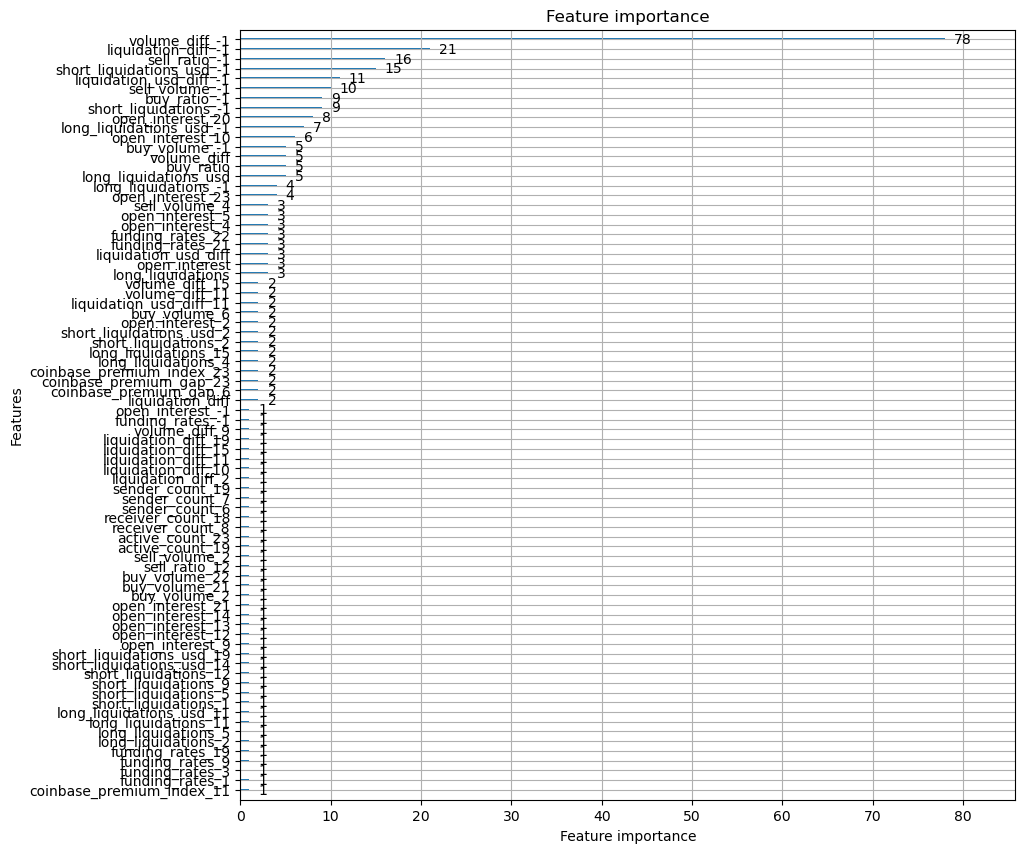

In [191]:
# Feature importance
lgb.plot_importance(lgb_model, figsize=(10, 10))

In [192]:
# volumn_diff 와 volume_diff_-1 의 scatter plot
fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=train_df["target"], y=train_df["volume_diff_-1"], mode="markers"),
    row=1,
    col=1,
)

In [193]:
# target 별 volume_diff_-1 평균
train_df.groupby("target")["volume_diff_-1"].mean()

target
0.0   -9.452717e+07
1.0   -1.944357e+07
2.0    1.482221e+07
3.0    8.754560e+07
Name: volume_diff_-1, dtype: float64

# feature 예측

## lgb regression model

In [194]:
def lgb_train(train_df: pd.DataFrame, feature: str) -> lgb.Booster:
    x_train = train_df.drop(["target", "ID", feature], axis=1)
    x_train = x_train[[col for col in x_train.columns if not col.endswith("-1")]]
    y_train = train_df[feature]
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42, stratify=train_df["target"]
    )
    train_data = lgb.Dataset(x_train, label=y_train)
    valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)
    params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 12,
        "learning_rate": 0.05,
        "n_estimators": 7,
        "random_state": 42,
        "verbose": 0,
    }
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )
    return lgb_model, x_train, y_train, x_valid, y_valid

### Buy Volume
target: buy_volume_-1

feature: "_-1" 로 끝나는 feature를 제외한 모든 feature

In [195]:
feature = "buy_volume_-1"
lgb_model, x_train, y_train, x_valid, y_valid = lgb_train(train_df, feature)
y_valid_pred = lgb_model.predict(x_valid)
rmse = (((y_valid - y_valid_pred) ** 2).mean())
print(rmse)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=y_valid, y=y_valid_pred, mode="markers"), row=1, col=1)

7.776153114683819e+16


/opt/homebrew/anaconda3/envs/venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

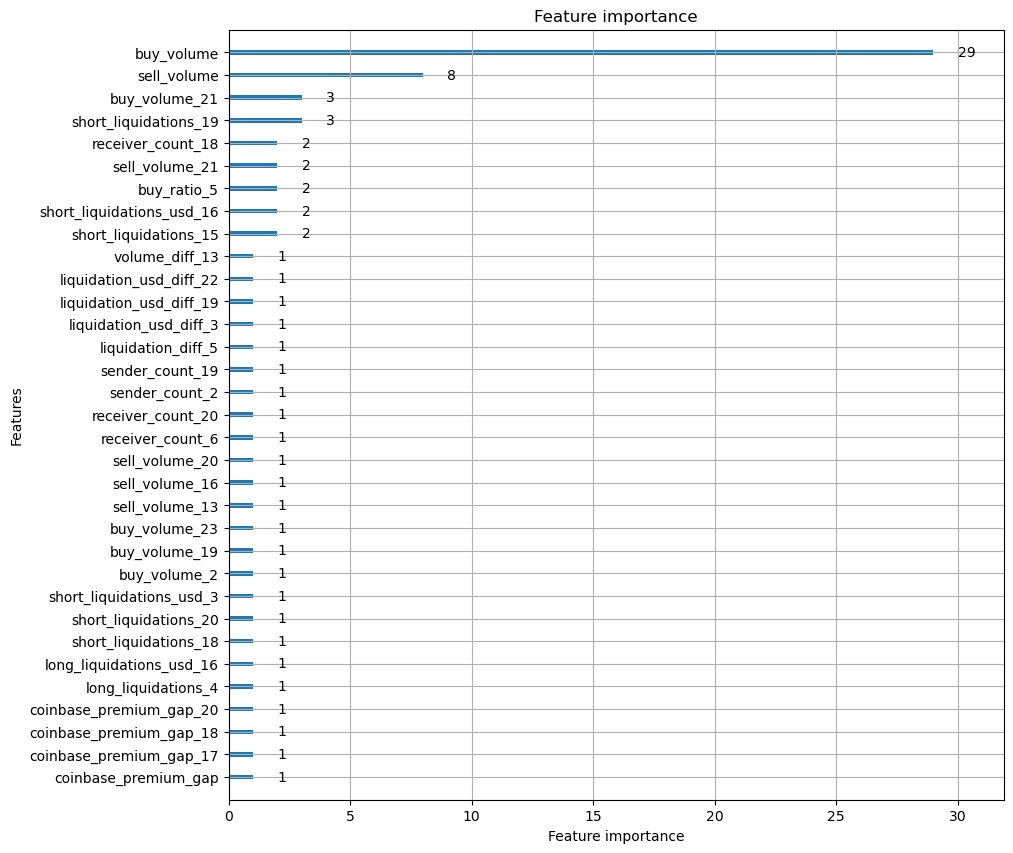

In [196]:
lgb.plot_importance(lgb_model, figsize=(10, 10))

### Sell Volume
target: sell_volume_-1

feature: "_-1" 로 끝나는 feature를 제외한 모든 feature

In [197]:
feature = "sell_volume_-1"
lgb_model, x_train, y_train, x_valid, y_valid = lgb_train(train_df, feature)
y_valid_pred = lgb_model.predict(x_valid)
rmse = (((y_valid - y_valid_pred) ** 2).mean())
print(rmse)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=y_valid, y=y_valid_pred, mode="markers"), row=1, col=1)

7.719688613445984e+16


/opt/homebrew/anaconda3/envs/venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

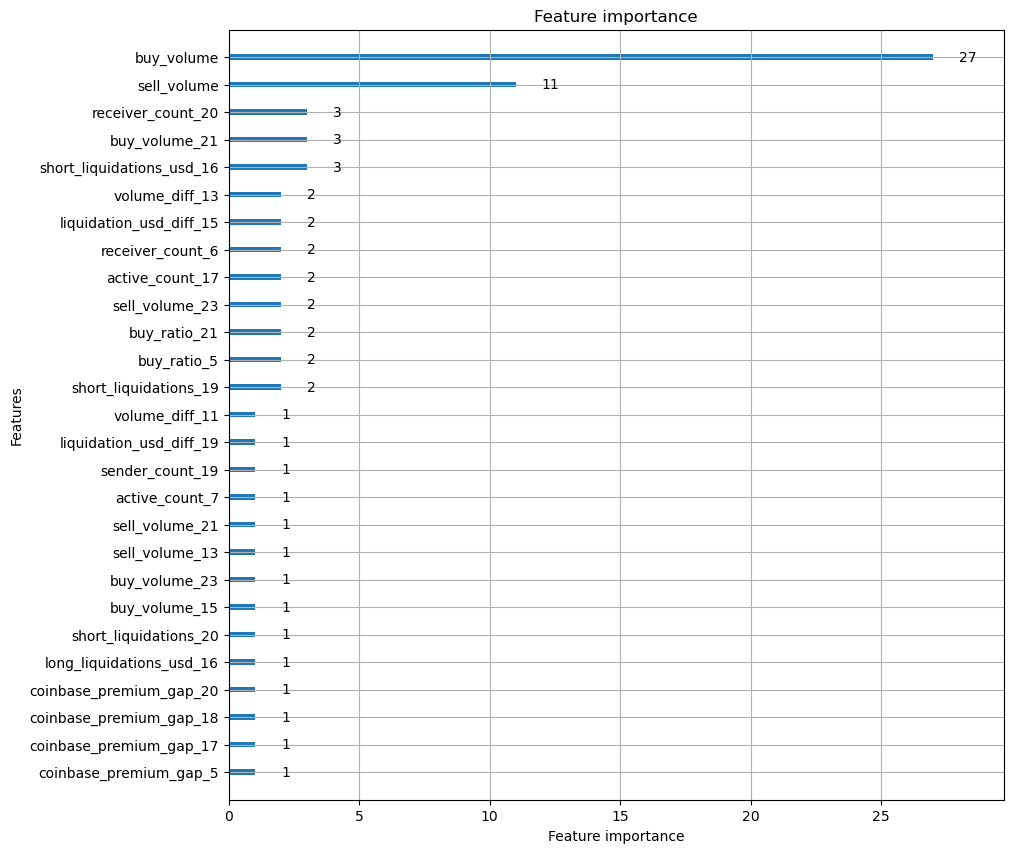

In [198]:
lgb.plot_importance(lgb_model, figsize=(10, 10))

## LSTM

In [199]:
# torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

# Using mps
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


In [200]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, output_dim: int):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        
        return out
    
# Custom Dataset, sequence length 만큼의 데이터를 묶어서 반환
class CustomDataset(Dataset):
    def __init__(self, data: np.ndarray, target: np.ndarray, seq_len: int):
        self.data = data
        self.target = target
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_len], self.target[idx+self.seq_len]

### sell_volume

In [211]:
scaler = StandardScaler()    
target_feature = "sell_volume_-1"
X = train_df.drop(["target", "ID", target_feature], axis=1)
X = X[[col for col in X.columns if not col.endswith("-1")]]
# shift 된 feature 는 제외
columns = X.columns
for i in range(1, 24):
    columns = columns.drop([col for col in X.columns if col.endswith(f"_{i}")])
X = X[columns]
# category_cols 는 제외
# X = X.drop(category_cols, axis=1)
y = train_df[target_feature]
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_df["target"])
x_train = scaler.fit_transform(x_train)
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.view(-1, 1)
x_valid = scaler.transform(x_valid)
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid.values).float()
y_valid = y_valid.view(-1, 1)

train_dataset = CustomDataset(x_train, y_train, seq_len=24)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_dim = x_train.shape[1]
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    losses = []
    loss_sum = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        outputs = model(x_batch.float())
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    losses.append(loss_sum/len(train_loader))
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}, loss: {loss_sum/len(train_loader)}")        

Epoch 10, loss: 1.804506449788511e+17
Epoch 20, loss: 1.7483233719232758e+17
Epoch 30, loss: 1.7580854394023504e+17
Epoch 40, loss: 1.7498666516760733e+17
Epoch 50, loss: 1.753825461252653e+17
Epoch 60, loss: 1.7481336761027133e+17
Epoch 70, loss: 1.758635848441719e+17
Epoch 80, loss: 1.750682805960108e+17
Epoch 90, loss: 1.7473666808429936e+17
Epoch 100, loss: 1.746562454464043e+17


In [212]:
# torch predict
model.eval()
x_valid = x_valid.view(-1, 1, input_dim)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)
y_valid_pred = model(x_valid)
y_valid_pred = y_valid_pred.cpu().detach().numpy()
rmse = (((y_valid.cpu().numpy() - y_valid_pred) ** 2).mean())
print(rmse)

1.6448417e+17


In [213]:
# torch predict plot
y_valid_pred = y_valid_pred.reshape(-1)
y_valid = y_valid.cpu().numpy().reshape(-1)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=y_valid, y=y_valid_pred, mode="markers"), row=1, col=1)

### Liquidation_diff

In [215]:
scaler = StandardScaler()    
target_feature = "liquidation_diff_-1"
X = train_df.drop(["target", "ID", target_feature], axis=1)
X = X[[col for col in X.columns if not col.endswith("-1")]]
# shift 된 feature 는 제외
columns = X.columns
for i in range(1, 24):
    columns = columns.drop([col for col in X.columns if col.endswith(f"_{i}")])
X = X[columns]
# category_cols 는 제외
# X = X.drop(category_cols, axis=1)
y = train_df[target_feature]
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_df["target"])
x_train = scaler.fit_transform(x_train)
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.view(-1, 1)
x_valid = scaler.transform(x_valid)
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid.values).float()
y_valid = y_valid.view(-1, 1)

train_dataset = CustomDataset(x_train, y_train, seq_len=24)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_dim = x_train.shape[1]
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    losses = []
    loss_sum = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        outputs = model(x_batch.float())
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    losses.append(loss_sum/len(train_loader))
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}, loss: {loss_sum/len(train_loader)}")        

Epoch 10, loss: 9951.995836847478
Epoch 20, loss: 8274.684842196379
Epoch 30, loss: 6887.82055941495
Epoch 40, loss: 5411.05824806907
Epoch 50, loss: 6008.796250221946
Epoch 60, loss: 4640.991238125888
Epoch 70, loss: 4420.695563853871
Epoch 80, loss: 4884.149544455789
Epoch 90, loss: 4268.643236194957
Epoch 100, loss: 4220.22855834961


In [216]:
# torch predict
model.eval()
x_valid = x_valid.view(-1, 1, input_dim)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)
y_valid_pred = model(x_valid)
y_valid_pred = y_valid_pred.cpu().detach().numpy()
rmse = (((y_valid.cpu().numpy() - y_valid_pred) ** 2).mean())
print(rmse)

19254.0


In [217]:
# torch predict plot
y_valid_pred = y_valid_pred.reshape(-1)
y_valid = y_valid.cpu().numpy().reshape(-1)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=y_valid, y=y_valid_pred, mode="markers"), row=1, col=1)

regeression Tree 모델과, LSTM 모델로 buy_volume과 sell_volume을 예측하는 실험 진행.
예측값과 기존값의 관계를 파악하기 어려웠음.
최종 모델 개발 중단.